In [1]:
import numpy as np
from scipy import interpolate
from scipy.integrate import ode
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

In [2]:
def create_cmap(color1, color2, color3):
    colors = [color1, color2, color3]
    cmap_name = 'list'
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
    return cmap

def lorenz(t, state, par): 
    σ, ρ, β = par
    x, y, z = state
    ẋ = σ * (y - x)
    ẏ = (x * (ρ - z)) - y
    ż = (x * y) - (β * z)
    dx = np.array((ẋ, ẏ, ż))
    return dx

def get_lorenz_data(tspan):
    σ, ρ, β = 10, 28, 8 / 3 # chaotic parameters 
    initial = np.array([-8, 8, 27]) # initial condition 
    data = np.empty((3, len(tspan)))
    data[:, 0] = initial
    r = ode(lorenz).set_integrator('dopri5')
    r.set_initial_value(initial, tspan[0])
    r.set_f_params((σ, ρ, β))
    for i, t in enumerate(tspan):
        if i == 0:
            continue
        r.integrate(t)
        data[:, i] = r.y
    return data 

def build_hankel(data, rows, cols):
    X = np.empty((rows, cols))
    for k in range(rows):
        X[k, :] = data[k:cols + k]
    return X 

def HAVOK(X, dt, r, norm, center=False, return_uv=False):
    if (center): 
        m = X.shape[0]
        X̄ = X - X[m//2,:]
        U, Σ, Vh = np.linalg.svd(X̄,full_matrices=False)
    else:
        U, Σ, Vh = np.linalg.svd(X,full_matrices=False)
    V = Vh.T
    polys = true_polys(X.shape[0], dt, r, center)
    for _i in range(r):
        if (np.dot(U[:,_i], polys[:,_i]) < 0):
            U[:,_i] *= -1
            V[:,_i] *= -1
    V1 = V[:-1,:r]
    V2 = V[1:,:r]
    A = (V2.T @ np.linalg.pinv(V1.T) - np.eye(r)) / (norm * dt)
    if (return_uv): 
        return A, U, V
    return A

def true_polys(rows, dt, r, center): 
    m = rows // 2
    Ut = np.linspace(-m*dt, m*dt, rows)
    poly_stack = []
    for j in range(r):
        if (center):
            poly_stack.append(Ut ** (j + 1))
        else: 
            poly_stack.append(Ut ** j)
    poly_stack = np.vstack(poly_stack).T
    Q = np.empty((rows, r)) # Perform Gram-Schmidt
    for j in range(r): 
        v = poly_stack[:, j]
        for k in range(j - 1): 
            r_jk = Q[:, k].T @ poly_stack[:, j]
            v -= (r_jk * Q[:, k])
        r_jj = np.linalg.norm(v)
        Q[:, j] = v / r_jj
    return Q

# Define colors and colormap 
color1 = 'peru'
color2 = 'tab:green'
color3 = 'tab:purple'
cmap = create_cmap('tab:blue','white','tab:orange')

In [3]:
# Time span over which to collect data
tmin = 0.0
tmax = 50.0

# Define hankel matrix parameters
r = 15
rows = 201

# Choose finely sampled time and size of skip
dt1 = 0.001
k = 100

# Finely sampled time 
tspan1 = np.arange(tmin, tmax + dt1, dt1)
all_data1 = get_lorenz_data(tspan1)
xdata1 = all_data1[0, :]
cols1 = xdata1.size - rows + 1
X1 = build_hankel(xdata1, rows, cols1)
A1, U1, _ = HAVOK(X1, dt1, r, 1, center=True, return_uv=True) 

# Increased time step
tspan2 = tspan1[::k]
dt2 = tspan2[1] - tspan2[0]
all_data2 = all_data1[:, ::k]
xdata2 = xdata1[::k]
cols2 = xdata2.size - rows + 1
X2 = build_hankel(xdata2, rows, cols2)
A2, U2, _ = HAVOK(X2, dt2, r, 1, center=True, return_uv=True) 

# Lorenz Data

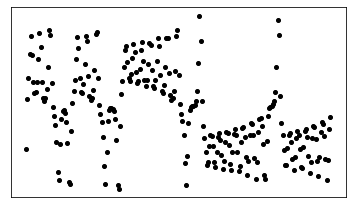

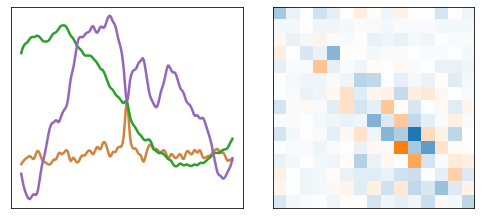

In [4]:
# Plot data 
plt.figure(figsize=(6,3.5))
plt.plot(tspan2[:len(tspan2)//2], xdata2[:len(tspan2)//2], '.', color='k', markersize=8)
plt.xticks([])
plt.yticks([])
plt.savefig('pdf_files/fig6a.pdf',bbox_inches='tight')

# Singular vectors and dynamics matrix
fig, ax = plt.subplots(sharex=True, figsize=(7,3.5))
ax.axis('off')

# Singular Vectors 
ax1 = fig.add_subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
ax1.plot(U2[:, 0], color=color1, label=r'$u_1$', linewidth=2.5)
ax1.plot(U2[:, 1], color=color2, label=r'$u_2$', linewidth=2.5)
ax1.plot(U2[:, 2], color=color3, label=r'$u_3$', linewidth=2.5)

# Dynamics Matrix 
ax2 = fig.add_subplot(1, 2, 2)
plt.imshow(A2,cmap=cmap)
plt.xticks([])
plt.yticks([])
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.savefig('pdf_files/fig6b.pdf',bbox_inches='tight')

# Interpolated Lorenz Data

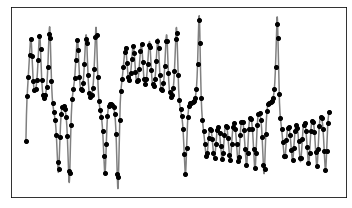

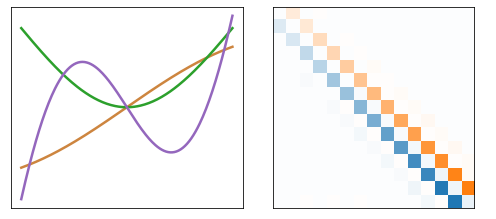

In [5]:
# Plot data 
plt.figure(figsize=(6,3.5))
plt.plot(tspan1[:len(tspan1)//2], xdata1[:len(tspan1)//2], color='gray')
plt.plot(tspan2[:len(tspan2)//2], xdata2[:len(tspan2)//2], '.', color='k', markersize=8)
plt.xticks([])
plt.yticks([])
plt.savefig('pdf_files/fig6c.pdf',bbox_inches='tight')

# Singular vectors and dynamics matrix
fig, ax = plt.subplots(sharex=True, figsize=(7, 3.5))
ax.axis('off')

# Singular Vectors 
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(U1[:, 0], color=color1, label=r'$u_1$', linewidth=2.5)
ax1.plot(U1[:, 1], color=color2, label=r'$u_2$', linewidth=2.5)
ax1.plot(U1[:, 2], color=color3, label=r'$u3$', linewidth=2.5)
plt.xticks([])
plt.yticks([])

# Dynamics Matrix 
ax2 = fig.add_subplot(1, 2, 2)
plt.imshow(A1,cmap=cmap)
plt.xticks([])
plt.yticks([])
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.savefig('pdf_files/fig6d.pdf',bbox_inches='tight')